In [21]:
import os
import urllib.request
import matplotlib.pyplot as plt

In [22]:
import mediapy as media
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from mediapy import show_videos  


In [23]:
train_csv =r"D:\\projects\\Gym Exercises Dataset\\train.csv"
val_csv =r"D:\\projects\\Gym Exercises Dataset\\test.csv"
test_csv = r"D:\\projects\\Gym Exercises Dataset\\val.csv"

In [26]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
val_df = pd.read_csv(val_csv)


In [27]:
print(test_df['label'].unique().tolist())


['Bicep Curl', 'Lateral Raise', 'Squat']


In [28]:
print("total number of training examples:" ,train_df['clip_name'].count())
print("total number of test examples:" ,test_df['clip_name'].count())
print("total number of validation examples:" ,val_df['clip_name'].count())

total number of training examples: 68
total number of test examples: 45
total number of validation examples: 47


In [29]:
epochs = 10
batch_size = 32
classes = ["Bicep Curl", "Lateral Raise", "Squat"]

In [30]:
file_paths, targets = [], []
for i, cls in enumerate(classes):
    for df in [train_df, test_df, val_df]:
        class_rows = df[df['label'] == cls]
        file_paths.extend(class_rows['clip_path'].tolist())
        targets.extend([i] * len(class_rows))

In [11]:
file_paths[0:6]

['\\train\\biceps curl\\barbell biceps curl_4.mp4',
 '\\train\\biceps curl\\barbell biceps curl_5.mp4',
 '\\train\\biceps curl\\barbell biceps curl_6.mp4',
 '\\train\\biceps curl\\barbell biceps curl_19.mp4',
 '\\train\\biceps curl\\barbell biceps curl_20.mp4',
 '\\train\\biceps curl\\barbell biceps curl_37.mp4']

In [12]:
targets[:5]

[0, 0, 0, 0, 0]

In [31]:
# Use Keras-based resizing and scaling
import cv2
import numpy as np
import random
from tqdm.notebook import tqdm
def format_frames(frame, output_size=(224, 224)):
    frame = tf.keras.layers.Rescaling(1.0 / 255.0)(frame)  
    frame = tf.image.resize_with_pad(frame, *output_size) 
    return frame

In [32]:
def frames_from_video_file(video_path, n_frames=10, output_size=(224, 224), frame_step=15):
    result = []
    src = cv2.VideoCapture(video_path)
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    start = random.randint(0, max(0, video_length - 1 - (n_frames - 1) * frame_step))
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))
        for _ in range(n_frames - 1):
            for _ in range(frame_step):
                src.read()
            ret, frame = src.read()
            if ret:
                result.append(format_frames(frame, output_size))
            else:
                result.append(tf.zeros_like(result[0]))
    src.release()
    if not result:
        dummy = tf.zeros([*output_size, 3])
        result = [dummy for _ in range(n_frames)]
    return np.array(result)[..., [2, 1, 0]]

In [33]:
features = np.array([frames_from_video_file(f, n_frames=10) for f in tqdm(file_paths)])  # Extract frames from videos

targets = np.array(targets)

  0%|          | 0/160 [00:00<?, ?it/s]

In [34]:
features.shape
targets.shape

(160,)

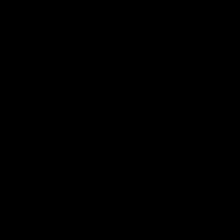

In [35]:
import glob  
import pandas as pd
import cv2 
import numpy as np
import random
import imageio 
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image  
from sklearn.metrics import confusion_matrix, classification_report

def to_gif(images):
    images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', images, fps=10)
    display(Image(filename='./animation.gif'))
    
# Visualize sample video
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
to_gif(sample_video)

In [36]:
import gc
# Train-test split (80% training, 20% validation)
train_features, val_features, train_targets, val_targets = train_test_split(
    features, targets, test_size=0.2, random_state=42  
)

# Create an optimized training dataset pipeline using tf.data
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_targets))  
    .shuffle(len(train_features))  
    .batch(batch_size)  
    .cache()  
    .prefetch(tf.data.AUTOTUNE) 
)
# Create an optimized training dataset pipeline using tf.data
valid_ds = (
    tf.data.Dataset.from_tensor_slices((val_features, val_targets))  # Convert data into a TensorFlow dataset
    .shuffle(len(train_features))  
    .batch(batch_size)  
    .cache()  
    .prefetch(tf.data.AUTOTUNE)  # Optimize performance by prefetching data
)


# Cleanup unused variables to free up memory
del features, targets  
gc.collect()  # Trigger garbage collection

1558

In [37]:
import tensorflow_hub as hub

# Load the I3D model from TensorFlow Hub
i3d_model = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [38]:
from keras import layers, models, optimizers

def build_i3d_model(num_classes=3, input_shape=(10, 224, 224, 3)):
    # Load pre-trained InceptionV3 model for RGB stream
    rgb_inception = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape[1:]  # (224, 224, 3)
    )
    
    # Freeze the InceptionV3 layers
    for layer in rgb_inception.layers:
        layer.trainable = False
    
    # Create the I3D model by inflating 2D convs to 3D
    inputs = layers.Input(shape=input_shape)
    
    # Inflate the InceptionV3 architecture to 3D
    x = layers.TimeDistributed(rgb_inception)(inputs)
    
    # 3D Convolutional layers
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((1, 2, 2), strides=(1, 2, 2), padding='same')(x)
    
    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='i3d_model')
    
    return model

# Build and compile the model
i3d_model = build_i3d_model(num_classes=len(classes), input_shape=(10, 224, 224, 3))

optimizer = optimizers.Adam(learning_rate=1e-4)
i3d_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
i3d_model.summary()

Model: "i3d_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 5, 5, 2048) │    21,802,784 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 5, 5, 64)   │     3,539,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 3, 3, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 3, 3, 128)  │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 2, 2, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 2, 2, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 5, 2, 2, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 1, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 3, 1, 1, 512)   │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 1, 1, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 1, 1, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 2, 1, 1, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 1, 1, 512)   │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 1, 1, 1, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,044,131 (206.16 MB)

 Trainable params: 32,241,347 (122.99 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3125 - loss: 1.0986 

4/4 ━━━━━━━━━━━━━━━━━━━━ 169s 29s/step - accuracy: 0.3125 - loss: 1.0986 - val_accuracy: 0.4062 - val_loss: 1.0983 - learning_rate: 1.0000e-04
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 61s 16s/step - accuracy: 0.3927 - loss: 1.0983 - val_accuracy: 0.4062 - val_loss: 1.0979 - learning_rate: 1.0000e-04
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 16s/step - accuracy: 0.3927 - loss: 1.0979 - val_accuracy: 0.4062 - val_loss: 1.0975 - learning_rate: 1.0000e-04
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 59s 16s/step - accuracy: 0.3927 - loss: 1.0976 - val_accuracy: 0.4062 - val_loss: 1.0962 - learning_rate: 1.0000e-04
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 16s/step - accuracy: 0.3927 - loss: 1.0969 - val_accuracy: 0.4062 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 16s/step - accuracy: 0.3927 - loss: 1.0959 - val_accuracy: 0.4062 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 15s/step - accuracy: 0.3927 - loss: 1.0950 - val_acc

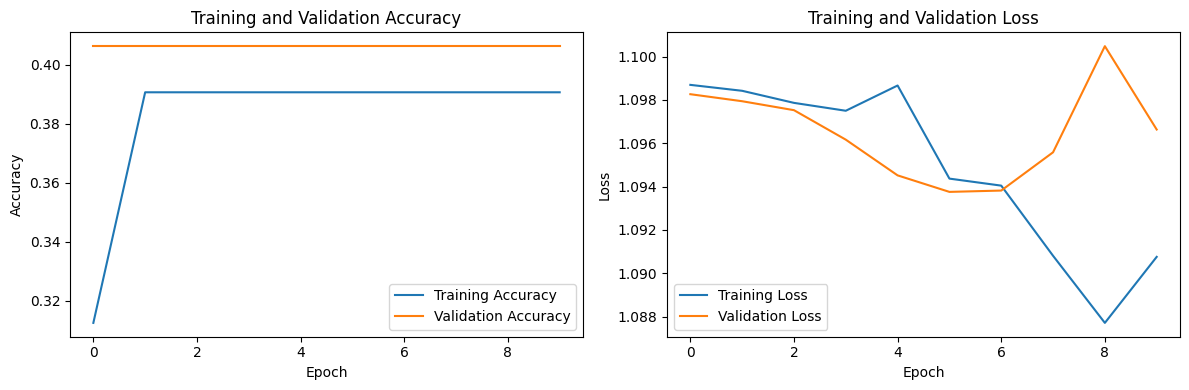

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4062 - loss: 1.0983

Test Accuracy: 0.4062
Test Loss: 1.0983
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step

Confusion Matrix:
[[13  0  0]
 [12  0  0]
 [ 7  0  0]]


In [39]:
# Add callbacks

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_i3d_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    )
]

# Train the model
history = i3d_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate the model
test_loss, test_acc = i3d_model.evaluate(valid_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = i3d_model.predict(valid_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(val_targets, y_pred_classes))
